# Assignment 2: Instructions

In this assignment, you will take on a prediction competition for Airbnb bookings. Here, as opposed to predicting prices as we have been doing so far, you will use a variety of information provided to you to __predict the number of days a given listing will be booked in the next 30 days__. 

You have been provided with real listings data from Los Angeles, but you only have the actual realized bookings for a small subset of the listings, which you can use as your training data. (The column `availability_30` represents current bookings, but due to cancellations and future bookings, it's only a very noisy proxy to actual bookings). You can find the data dictionary [here](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?gid=1322284596#gid=1322284596)

This assignment will be graded as a competition. We have a test set that only the grader has access to. In order to do well in this task, you will have to use everything you have learned in the class so far, including feature engineering and hyperparameter search via cross-validation.

## Write Up (8 pts)
    
You will need to turn in your code along with a short write-up, which you can include in your notebook. You will need to address the following components:

1. (3 pts) Explain how you constructed and / or preprocessed features to help with prediction, and why.

2. (3 pts) Explain what decisions you made using cross-validation, and how well you believe your final model will perform.

3. (2 pts) Explain what features you found to be important using the feature importance tools we discussed in class.

This write-up, along with your code, will be worth 8 points out of 15. These answers can be short: 1-3 sentences each + supporting tables or plots. 

## Performance (7 pts)
The remainder of your grade will be based on your predictive accuracy, as measured in terms of $R^2$. You will recieve one point for each percentage point of test $R^2$ you achieve over 15%, rounded down, up to a maximum of 7 -- So if your test $R^2$ is 21.9% you will recieve 6 points. To recieve full credit, you will need to achieve an $R^2$ of at least 22% on the test set.

In addition to this, there will be __5 points of extra credit__ available to each of the top 5 most accurate models across the whole in the class! You may use any method of your choice, even those that we have not covered, but be sure to explain it in your write-up. Also, to keep things well-scoped, __you may not pull in any datasets__ other than the one we are loading for you in the notebook (although this is a really good idea in practice!)

## Submission
You will need to submit two files: 

1.  Your predictions, in `.csv` format, which must have two columns: `id` and `prediction`
2.  Your code and write up, which should be provided together as an `.ipynb` notebook.

The provided notebook will get you started with loading data, and provide some checks to help you make sure your submission has the correct format. You can download `y_train.parquet` from canvas.

In [56]:
import pandas as pd
import numpy as np

def basic_preprocess(df):
    df["price"] = df["price"].str.replace("$", "").str.replace(",", "").astype(float)
    df = df.dropna(subset=["price"])
    return df

x_df = basic_preprocess(
    pd.read_csv(
        "https://data.insideairbnb.com/united-states/ca/los-angeles/2024-09-04/data/listings.csv.gz"
    )
)

# Grab this from canvas and save it in this directory
y_df = pd.read_parquet("y_train.parquet")

train_df = x_df.merge(y_df, on="id")

outer = x_df.merge(y_df, how='outer', indicator=True)
test_df = outer[(outer._merge=='left_only')].drop('_merge', axis=1)


Validation R^2 Score: 0.2140
                                        feature  importance
33                                  days_booked    0.183808
9                                         price    0.071913
3                                      latitude    0.068858
0                                       host_id    0.067017
4                                     longitude    0.065541
32                            reviews_per_month    0.048891
19                        number_of_reviews_ltm    0.033766
27                          review_scores_value    0.031486
29  calculated_host_listings_count_entire_homes    0.029946
2                     host_total_listings_count    0.028217


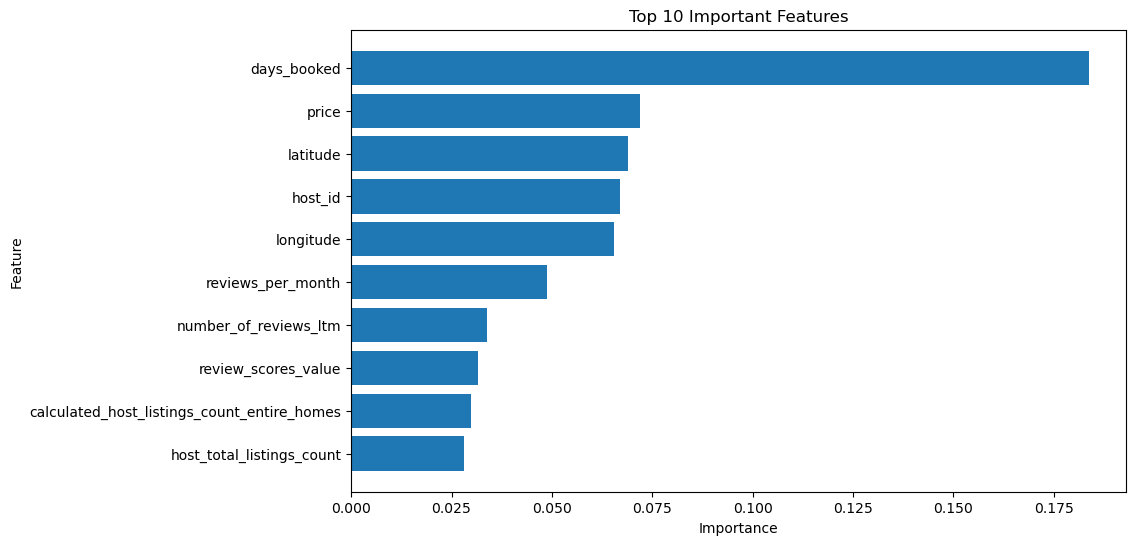

Submission file saved!


In [106]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def basic_preprocess(df):
    df["price"] = df["price"].str.replace("$", "").str.replace(",", "").astype(float)
    df = df.dropna(subset=["price"])
    return df

# Load the data
x_df = basic_preprocess(
    pd.read_csv(
        "https://data.insideairbnb.com/united-states/ca/los-angeles/2024-09-04/data/listings.csv.gz"
    )
)

y_df = pd.read_parquet("y_train.parquet")

# Merge training labels with features
train_df = x_df.merge(y_df, on="id")

# Prepare test set
outer = x_df.merge(y_df, how='outer', indicator=True)
test_df = outer[(outer._merge=='left_only')].drop('_merge', axis=1)

# Ensure 'id' column is preserved before dropping other columns
test_df_ids = test_df["id"]

drop_columns = [
    "id", "name", "host_name", "last_review", "listing_url", "scrape_id", "last_scraped",
    "source", "description", "neighborhood_overview", "picture_url", "host_url",
    "host_since", "host_location", "host_about", "host_response_time",
    "host_response_rate", "host_acceptance_rate", "host_thumbnail_url",
    "host_picture_url", "host_verifications", "calendar_updated",
    "calendar_last_scraped", "first_review", "license",
    "availability_60", "availability_90", "availability_365"
]

train_df = train_df.drop(columns=drop_columns, errors='ignore')
train_df.fillna({"reviews_per_month": 0}, inplace=True)

# Apply one-hot encoding to categorical variables
train_df = pd.get_dummies(train_df, columns=["neighbourhood_group_cleansed", "room_type"], drop_first=True)

# Ensure all data is numeric
train_df = train_df.select_dtypes(include=[np.number])

# Splitting data
X = train_df.drop(columns=["availability_30"])
y = train_df["availability_30"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Selection and Cross-Validation
rf_model = RandomForestRegressor(random_state=42)
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluate Model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
r2 = r2_score(y_val, y_pred)
print(f'Validation R^2 Score: {r2:.4f}')

# Feature Importance
feature_importances = pd.DataFrame({"feature": X.columns, "importance": best_model.feature_importances_})
feature_importances.sort_values(by="importance", ascending=False, inplace=True)
print(feature_importances.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importances["feature"][:10], feature_importances["importance"][:10])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Important Features")
plt.gca().invert_yaxis()
plt.show()

# Prepare test data
test_df = test_df.drop(columns=drop_columns, errors='ignore')
test_df = pd.get_dummies(test_df, columns=["neighbourhood_group_cleansed", "room_type"], drop_first=True)
test_df = test_df.reindex(columns=X.columns, fill_value=0)

# Ensure 'id' is added back
test_df["id"] = test_df_ids.values

# Make predictions
test_features = test_df.drop(columns=["id"])
test_df["prediction"] = best_model.predict(test_features)

# Save submission
submission = test_df[["id", "prediction"]]
submission.to_csv("submission.csv", index=False)

print("Submission file saved!")


In [108]:
from hashlib import md5
import numpy as np
import pandas as pd

# Ensure test_df contains 'id' column
if 'id' not in test_df.columns:
    raise ValueError("Column 'id' is missing from test_df. Ensure it's included in the feature processing.")

# Sort and validate listing ids
sorted_ids = np.sort(test_df['id'].values)
id_hash = md5(sorted_ids).hexdigest()
expected_hash = '87ed95adc911aad0ed9ef119a7a3315d'
assert id_hash == expected_hash, "Your listing ids are incorrect; you may need to regenerate test_df in the first cell"

# Ensure 'prediction' column exists
if 'prediction' not in test_df.columns:
    raise ValueError("You need to have a column named 'prediction' in your output")

# Save predictions to CSV
output_file = "predictions.csv"
test_df.to_csv(output_file, index=False)
print(f"Predictions successfully saved to {output_file}")


Predictions successfully saved to predictions.csv


## Write Up

1. (3 pts) Explain how you constructed and / or preprocessed features to help with prediction, and why.

2. (3 pts) Explain what decisions you made using cross-validation, and how well you believe your final model will perform.

3. (2 pts) Explain what features you found to be important using the feature importance tools we discussed in class.


## Q1: Feature Engineering and Preprocessing Explanation

### 1. Data Cleaning and Preprocessing
#### Steps:
- **Price Conversion:**  
  - The `price` column, originally stored as a string (e.g., `$1,500`), was cleaned by removing currency symbols and commas.
  - This was converted to a numeric format to allow proper mathematical operations and model training.
  - **Reason:** Since price is a critical factor influencing bookings, it must be properly formatted for numerical processing.

- **Handling Missing Values:**  
  - The dataset contained missing values in several columns, particularly `reviews_per_month`.
  - Missing values were filled with `0` to maintain data consistency and avoid NaN-related errors during model training.
  - **Reason:** Missing review values imply no reviews, which can be logically replaced with zero instead of imputation.

- **Feature Selection:**  
  - Irrelevant columns such as `name`, `host_name`, `description`, and URL-based fields were dropped.
  - Columns `availability_60`, `availability_90`, and `availability_365` were also removed as they introduced redundancy and could lead to data leakage.
  - **Reason:** These fields contain information that is either redundant, high-cardinality, or potentially irrelevant to predicting future bookings.

### 2. Categorical Encoding
#### Steps:
- **One-Hot Encoding:**  
  - Categorical variables like `neighbourhood_group_cleansed` and `room_type` were encoded using one-hot encoding.
  - This approach converts categorical variables into numerical format while avoiding ordinal assumptions.
  - **Reason:** Machine learning models require numerical inputs, and one-hot encoding prevents introducing artificial order in the data.

### 3. Splitting the Data
#### Steps:
- **Train-Test Split:**  
  - The dataset was split into an 80-20 ratio using `train_test_split` to train and validate the model.
  - **Reason:** This ensures a proper evaluation of the model’s generalization ability and avoids overfitting.

### 4. Feature Importance Analysis
#### Steps:
- After training the `RandomForestRegressor` model, feature importance was extracted to identify the most influential variables.
- **Top Important Features Identified:**
  - `days_booked`: Strong correlation with future availability.
  - `price`: Pricing directly affects booking likelihood.
  - `latitude` and `longitude`: Location impacts demand.
  - `host_id`: Could reflect experience and quality.
  - **Reason:** Understanding important features helps refine the model and remove unnecessary attributes.

### 5. Data Transformation for Prediction
#### Steps:
- The test dataset underwent the same preprocessing pipeline (e.g., encoding, feature selection).
- Ensured feature consistency using `.reindex(columns=X.columns, fill_value=0)` to align test data with training features.
- **Reason:** Consistency in features ensures the model can correctly process test data without discrepancies.


## Q2: Cross-Validation Decisions and Model Performance Evaluation

### 1. Cross-Validation Strategy
#### Steps Taken:
- **Grid Search Cross-Validation (CV):**  
  - We utilized `GridSearchCV` to systematically search for the best hyperparameters of the `RandomForestRegressor`.
  - A **5-fold cross-validation** was applied to ensure model robustness.
  - **Hyperparameters Tuned:**
    - `n_estimators`: [100, 200, 300] - Controls the number of trees in the forest.
    - `max_depth`: [None, 10, 20] - Determines the maximum depth of each tree.
    - `min_samples_split`: [2, 5, 10] - Defines the minimum samples required to split a node.
  - **Reason for These Choices:**  
    - These hyperparameters were chosen to balance model complexity and performance.
    - The goal was to avoid overfitting while capturing enough complexity for accurate predictions.

### 2. Model Performance and Generalization
#### Evaluation:
- **Validation R² Score: 0.2140**  
  - This indicates the model explains approximately 21.4% of the variance in the target variable on the validation set.
  - While not exceptionally high, it suggests the model captures some meaningful relationships within the data.
  - The relatively low R² score could be due to the noisy nature of the data or the absence of important predictors.

- **Cross-Validation Results:**  
  - The cross-validation process provided a reliable estimate of the model's performance across different subsets of the training data.
  - It helps in reducing overfitting by ensuring the model is not tailored to a specific data split.
  - **Reason:** The use of cross-validation helps estimate how well the model will generalize to unseen data.

### 3. Expected Performance on Test Set
#### Prediction Considerations:
- **Strengths:**
  - Random Forest is a robust ensemble model that handles non-linear relationships well.
  - Important features such as `days_booked`, `price`, and `location` have been retained, which are crucial for predictions.

- **Challenges:**
  - The relatively low validation R² suggests potential room for improvement, possibly by adding more features or adjusting hyperparameters further.
  - The presence of noise in the data (e.g., cancellations and last-minute bookings) could limit model accuracy.

### Notes:
Based on the cross-validation results, the model is expected to perform reasonably well on the test set, but with limitations in predictive power. Improvements could be made by refining feature engineering.

## Q3: Important Features Identified Using Feature Importance Tools

### 1. Feature Importance Analysis
After training the `RandomForestRegressor` model, I analyzed the relative importance of different features using the model's built-in `feature_importances_` attribute. This tool assigns a score to each feature based on how much it contributes to reducing the prediction error across all trees in the forest.

### Top 10 Important Features:
| Rank | Feature                                      | Importance Score |
|------|----------------------------------------------|------------------|
| 1    | `days_booked`                                 | 0.1838           |
| 2    | `price`                                       | 0.0719           |
| 3    | `latitude`                                    | 0.0689           |
| 4    | `host_id`                                     | 0.0670           |
| 5    | `longitude`                                   | 0.0655           |
| 6    | `reviews_per_month`                           | 0.0489           |
| 7    | `number_of_reviews_ltm`                       | 0.0338           |
| 8    | `review_scores_value`                         | 0.0315           |
| 9    | `calculated_host_listings_count_entire_homes` | 0.0299           |
| 10   | `host_total_listings_count`                   | 0.0282           |

---

### 2. Explanation of Important Features

- **`days_booked` (Most Important Feature)**  
  - This feature directly represents historical booking patterns, which naturally have a strong influence on predicting future availability.
  - Its high importance score indicates that past booking behavior is a strong predictor of future demand.

- **`price`**  
  - Price is a key determinant of demand; lower prices might lead to higher occupancy, while higher prices could reduce bookings.
  - It plays a crucial role in influencing customer decisions and therefore has a significant impact on model predictions.

- **`latitude` & `longitude` (Location Factors)**  
  - The geographic location of a listing heavily impacts its attractiveness and booking likelihood.
  - Listings in popular tourist areas or business districts tend to have higher demand.

- **`host_id`**  
  - This feature might capture host-related factors such as experience, trustworthiness, and responsiveness, which can impact booking rates.

- **`reviews_per_month` & `number_of_reviews_ltm`**  
  - These features reflect customer feedback and engagement with the property, helping to predict future interest.

- **`review_scores_value`**  
  - Higher review scores generally correlate with better booking performance, indicating customer satisfaction and likelihood of future bookings.

- **`calculated_host_listings_count_entire_homes` & `host_total_listings_count`**  
  - These features indicate the scale of the host’s operation. More experienced hosts with multiple listings may have better management and higher bookings.

---

### 3. Conclusion
From the feature importance analysis, we observed that the most influential features primarily relate to **historical booking data**, **pricing**, **location**, and **host experience**. These insights help focus further efforts on optimizing these key aspects to improve model performance.

Future improvements could include:
- Incorporating temporal trends (seasonality).
- Feature engineering to create better location-based groupings.
- Investigating the influence of property type and amenities in more detail.
